In [1]:
from dotenv import load_dotenv
load_dotenv("../.env")

True

In [28]:
from typing import Literal
from datetime import datetime
from pydantic import BaseModel
from langchain_core.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

@tool
class Done(BaseModel):
      """E-mail has been sent."""
      done: bool


Done(done=True)

In [3]:
from langgraph.graph import MessagesState

class State(MessagesState):
    # We can add a specific key to our state for the email input
    email_input: dict
    classification_decision: Literal["ignore", "respond", "notify"]

In [ ]:
from pydantic import BaseModel, Field
from email_assistant.utils import parse_email, format_email_markdown
from email_assistant.utils.prompts import triage_system_prompt, triage_user_prompt, default_triage_instructions, default_background
from langchain.chat_models import init_chat_model
from langgraph.graph import END
from langgraph.types import Command

In [6]:
from rich.markdown import Markdown
Markdown(triage_system_prompt)

< Role > Your role is to triage incoming emails based upon instructs and background information below. </ Role >   

< Background > {background}. </ Background >                                                                       

< Instructions > Categorize each email into one of three categories:                                               

 1 IGNORE - Emails that are not worth responding to or tracking                                                    
 2 NOTIFY - Important information that worth notification but doesn't require a response                           
 3 RESPOND - Emails that need a direct response Classify the below email into one of these categories. </          
   Instructions >                                                                                                  

< Rules > {triage_instructions} </ Rules >

In [7]:
Markdown(triage_user_prompt)

Please determine how to handle the below email thread:                                                             

From: {author} To: {to} Subject: {subject} {email_thread}

In [8]:
Markdown(default_background)

I'm Lance, a software engineer at LangChain.

In [9]:
Markdown(default_triage_instructions)

Emails that are not worth responding to:                                                                           

 • Marketing newsletters and promotional emails                                                                    
 • Spam or suspicious emails                                                                                       
 • CC'd on FYI threads with no direct questions                                                                    

There are also other things that should be known about, but don't require an email response. For these, you should 
notify (using the notify response). Examples of this include:                                                      

 • Team member out sick or on vacation                                                                             
 • Build system notifications or deployments                                                                       
 • Project status updates without action items                                                                     
 • Important company announcements                                                                                 
 • FYI emails that contain relevant information for current projects                                               
 • HR Department deadline reminders                                                                                
 • Subscription status / renewal reminders                                                                         
 • GitHub notifications                                                                                            

Emails that are worth responding to:                                                                               

 • Direct questions from team members requiring expertise                                                          
 • Meeting requests requiring confirmation                                                                         
 • Critical bug reports related to team's projects                                                                 
 • Requests from management requiring acknowledgment                                                               
 • Client inquiries about project status or features                                                               
 • Technical questions about documentation, code, or APIs (especially questions about missing endpoints or         
   features)                                                                                                       
 • Personal reminders related to family (wife / daughter)                                                          
 • Personal reminder related to self-care (doctor appointments, etc)

In [10]:
class RouterSchema(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

# Initialize the LLM for use with router / structured output
llm = init_chat_model("openai:gpt-4.1", temperature=0.0)
llm_router = llm.with_structured_output(RouterSchema) 

def triage_router(state: State) -> Command[Literal["response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore."""
    
    author, to, subject, email_thread = parse_email(state["email_input"])
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=default_triage_instructions
    )

    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email: \n\n{format_email_markdown(subject, author, to, email_thread)}",
                }
            ],
            "classification_decision": result.classification,
        }
        
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        goto = END
        update =  {
            "classification_decision": result.classification,
        }
        
    elif result.classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information")
        # For now, we go to END. But we will add to this later!
        goto = END
        update = {
            "classification_decision": result.classification,
        }
        
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

In [ ]:
from email_assistant.tools.default.prompt_templates import AGENT_TOOLS_PROMPT
from email_assistant.utils.prompts import agent_system_prompt, default_response_preferences, default_cal_preferences

In [12]:
Markdown(AGENT_TOOLS_PROMPT)

 1 write_email(to, subject, content) - Send emails to specified recipients                                         
 2 schedule_meeting(attendees, subject, duration_minutes, preferred_day, start_time) - Schedule calendar meetings  
   where preferred_day is a datetime object                                                                        
 3 check_calendar_availability(day) - Check available time slots for a given day                                   
 4 Done - E-mail has been sent

In [13]:
Markdown(agent_system_prompt)

< Role > You are a top-notch executive assistant who cares about helping your executive perform as well as         
possible. </ Role >                                                                                                

< Tools > You have access to the following tools to help manage communications and schedule: {tools_prompt} </     
Tools >                                                                                                            

< Instructions > When handling emails, follow these steps:                                                         

 1 Carefully analyze the email content and purpose                                                                 
 2 IMPORTANT --- always call a tool and call one tool at a time until the task is complete:                        
 3 For responding to the email, draft a response email with the write_email tool                                   
 4 For meeting requests, use the check_calendar_availability tool to find open time slots                          
 5 To schedule a meeting, use the schedule_meeting tool with a datetime object for the preferred_day parameter     
    • Today's date is 2025-06-29 - use this for scheduling meetings accurately                                     
 6 If you scheduled a meeting, then draft a short response email using the write_email tool                        
 7 After using the write_email tool, the task is complete                                                          
 8 If you have sent the email, then use the Done tool to indicate that the task is complete </ Instructions >      

< Background > {background} </ Background >                                                                        

< Response Preferences > {response_preferences} </ Response Preferences >                                          

< Calendar Preferences > {cal_preferences} </ Calendar Preferences >

In [14]:
# Collect all tools
tools = [write_email, schedule_meeting, check_calendar_availability, Done]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize the LLM, enforcing tool use
llm = init_chat_model("openai:gpt-4.1", temperature=0.0)
llm_with_tools = llm.bind_tools(tools, tool_choice="any")

def llm_call(state: State):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            # Invoke the LLM
            llm_with_tools.invoke(
                # Add the system prompt
                [   
                    {"role": "system", "content": agent_system_prompt.format(
                        tools_prompt=AGENT_TOOLS_PROMPT,
                        background=default_background,
                        response_preferences=default_response_preferences,
                        cal_preferences=default_cal_preferences, 
                    )}
                ]
                # Add the current messages to the prompt
                + state["messages"]
            )
        ]
    }

In [15]:
def tool_handler(state: State):
    """Performs the tool call."""

    # List for tool messages
    result = []
    
    # Iterate through tool calls
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = tools_by_name[tool_call["name"]]
        # Run it
        observation = tool.invoke(tool_call["args"])
        # Create a tool message
        result.append({"role": "tool", "content" : observation, "tool_call_id": tool_call["id"]})
    
    # Add it to our messages
    return {"messages": result}

In [17]:
def should_continue(state: State) -> Literal["tool_handler", "__end__"]:
    """Route to tool handler, or end if Done tool called."""
    
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if it's a Done tool call
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "tool_handler"

In [18]:
from langgraph.graph import StateGraph, START, END
from email_assistant.utils import show_graph

# Build workflow
overall_workflow = StateGraph(State)

# Add nodes
overall_workflow.add_node("llm_call", llm_call)
overall_workflow.add_node("tool_handler", tool_handler)

# Add edges
overall_workflow.add_edge(START, "llm_call")
overall_workflow.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_handler": "tool_handler",
        END: END,
    },
)
overall_workflow.add_edge("tool_handler", "llm_call")

# Compile the agent
agent = overall_workflow.compile()

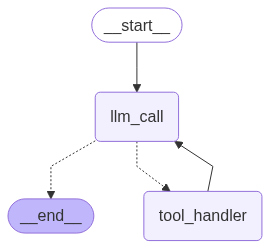

In [19]:
# View
show_graph(agent)

In [20]:
overall_workflow = (
    StateGraph(State)
    .add_node(triage_router)
    .add_node("response_agent", agent)
    .add_edge(START, "triage_router")
).compile()

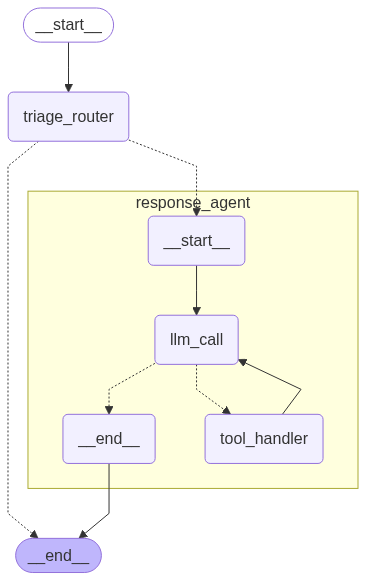

In [21]:
show_graph(overall_workflow, xray=True)

In [22]:
email_input = {
    "author": "System Admin <sysadmin@company.com>",
    "to": "Development Team <dev@company.com>",
    "subject": "Scheduled maintenance - database downtime",
    "email_thread": "Hi team,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"
}

# Run the agent
response = overall_workflow.invoke({"email_input": email_input})
for m in response["messages"]:
    m.pretty_print()

🔔 Classification: NOTIFY - This email contains important information


In [23]:
email_input = {
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}

# Run the agent
response = overall_workflow.invoke({"email_input": email_input})
for m in response["messages"]:
    m.pretty_print()

📧 Classification: RESPOND - This email requires a response
================================ Human Message =================================

Respond to the email: 



**Subject**: Quick question about API documentation
**From**: Alice Smith <alice.smith@company.com>
**To**: John Doe <john.doe@company.com>

Hi John,
I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?
Specifically, I'm looking at:
- /auth/refresh
- /auth/validate
Thanks!
Alice

---

================================== Ai Message ==================================
Tool Calls:
  write_email (call_EPl1GclVH7ytrOn94cirukU4)
 Call ID: call_EPl1GclVH7ytrOn94cirukU4
  Args:
    to: alice.smith@company.com
    subject: Re: Quick question about API documentation
    content: Hi Alice,

Thank you for bringing this to my attention. I'll investigate whether the /auth/refre

In [29]:
from email_assistant.eval.email_dataset import email_inputs, expected_tool_calls, triage_outputs_list, response_criteria_list

test_case_ix = 0

print("Email Input:", email_inputs[test_case_ix])
print("Expected Triage Output:", triage_outputs_list[test_case_ix])
print("Expected Tool Calls:", expected_tool_calls[test_case_ix])
print("Response Criteria:", response_criteria_list[test_case_ix])

Email Input: {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'Lance Martin <lance@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi Lance,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
Expected Triage Output: respond
Expected Tool Calls: ['write_email', 'done']
Response Criteria: 
• Send email with write_email tool call to acknowledge the question and confirm it will be investigated  



In [31]:
import pytest
from email_assistant.eval.email_dataset import email_inputs, expected_tool_calls
from email_assistant.utils import format_messages_string
from email_assistant.email_assistant import email_assistant
from email_assistant.utils import extract_tool_calls

from langsmith import testing as t

@pytest.mark.langsmith
@pytest.mark.parametrize(
    "email_input, expected_calls",
    [   # Pick some examples with e-mail reply expected
        (email_inputs[0],expected_tool_calls[0]),
        (email_inputs[3],expected_tool_calls[3]),
    ],
)
def test_email_dataset_tool_calls(email_input, expected_calls):
    """Test if email processing contains expected tool calls.
    
    This test confirms that all expected tools are called during email processing,
    but does not check the order of tool invocations or the number of invocations
    per tool. Additional checks for these aspects could be added if desired.
    """
    # Run the email assistant
    messages = [{"role": "user", "content": str(email_input)}]
    result = email_assistant.invoke({"messages": messages})
            
    # Extract tool calls from messages list
    extracted_tool_calls = extract_tool_calls(result['messages'])
            
    # Check if all expected tool calls are in the extracted ones
    missing_calls = [call for call in expected_calls if call.lower() not in extracted_tool_calls]
    
    t.log_outputs({
                "missing_calls": missing_calls,
                "extracted_tool_calls": extracted_tool_calls,
                "response": format_messages_string(result['messages'])
            })

    # Test passes if no expected calls are missing
    assert len(missing_calls) == 0

In [32]:
from langsmith import Client

from email_assistant.eval.email_dataset import examples_triage

# Initialize LangSmith client
client = Client()

# Dataset name
dataset_name = "E-mail Triage Evaluation"

# Create dataset if it doesn't exist
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(
        dataset_name=dataset_name, 
        description="A dataset of e-mails and their triage decisions."
    )
    # Add examples to the dataset
    client.create_examples(dataset_id=dataset.id, examples=examples_triage)

In [33]:
print("Dataset Example Input (inputs):", examples_triage[0]['inputs'])

Dataset Example Input (inputs): {'email_input': {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'Lance Martin <lance@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi Lance,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}}


In [34]:
print("Dataset Example Reference Output (reference_outputs):", examples_triage[0]['outputs'])

Dataset Example Reference Output (reference_outputs): {'classification': 'respond'}


In [35]:
def target_email_assistant(inputs: dict) -> dict:
    """Process an email through the workflow-based email assistant."""
    response = email_assistant.nodes['triage_router'].invoke({"email_input": inputs["email_input"]})
    return {"classification_decision": response.update['classification_decision']}

In [36]:
def classification_evaluator(outputs: dict, reference_outputs: dict) -> bool:
    """Check if the answer exactly matches the expected answer."""
    return outputs["classification_decision"].lower() == reference_outputs["classification"].lower()

In [37]:
# Set to true if you want to kick off evaluation
run_expt = True
if run_expt:
    experiment_results_workflow = client.evaluate(
        # Run agent 
        target_email_assistant,
        # Dataset name   
        data=dataset_name,
        # Evaluator
        evaluators=[classification_evaluator],
        # Name of the experiment
        experiment_prefix="E-mail assistant workflow", 
        # Number of concurrent evaluations
        max_concurrency=2, 
    )

View the evaluation results for experiment: 'E-mail assistant workflow-54376d20' at:
https://smith.langchain.com/o/3fd079fe-8adf-41f3-8f5d-e6ed0b605c27/datasets/c00430f2-cc7d-4538-9d78-838735052e2e/compare?selectedSessions=f13544d8-f241-481d-aa8d-ef20aabe7afd




0it [00:00, ?it/s]

🔔 Classification: NOTIFY - This email contains important information
📧 Classification: RESPOND - This email requires a response
📧 Classification: RESPOND - This email requires a response
📧 Classification: RESPOND - This email requires a response
🚫 Classification: IGNORE - This email can be safely ignored
📧 Classification: RESPOND - This email requires a response
📧 Classification: RESPOND - This email requires a response
🔔 Classification: NOTIFY - This email contains important information
🚫 Classification: IGNORE - This email can be safely ignored
📧 Classification: RESPOND - This email requires a response
📧 Classification: RESPOND - This email requires a response
🔔 Classification: NOTIFY - This email contains important information
🔔 Classification: NOTIFY - This email contains important information
🚫 Classification: IGNORE - This email can be safely ignored
🔔 Classification: NOTIFY - This email contains important information
📧 Classification: RESPOND - This email requires a response


In [38]:
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model

class CriteriaGrade(BaseModel):
    """Score the response against specific criteria."""
    justification: str = Field(description="The justification for the grade and score, including specific examples from the response.")
    grade: bool = Field(description="Does the response meet the provided criteria?")
    
# Create a global LLM for evaluation to avoid recreating it for each test
criteria_eval_llm = init_chat_model("openai:gpt-4o")
criteria_eval_structured_llm = criteria_eval_llm.with_structured_output(CriteriaGrade)

In [39]:
email_input = email_inputs[0]
print("Email Input:", email_input)
success_criteria = response_criteria_list[0]
print("Success Criteria:", success_criteria)

Email Input: {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'Lance Martin <lance@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi Lance,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
Success Criteria: 
• Send email with write_email tool call to acknowledge the question and confirm it will be investigated  



In [40]:
response = email_assistant.invoke({"email_input": email_input})

📧 Classification: RESPOND - This email requires a response


In [41]:
from email_assistant.eval.prompts import RESPONSE_CRITERIA_SYSTEM_PROMPT

all_messages_str = format_messages_string(response['messages'])
eval_result = criteria_eval_structured_llm.invoke([
        {"role": "system",
            "content": RESPONSE_CRITERIA_SYSTEM_PROMPT},
        {"role": "user",
            "content": f"""\n\n Response criteria: {success_criteria} \n\n Assistant's response: \n\n {all_messages_str} \n\n Evaluate whether the assistant's response meets the criteria and provide justification for your evaluation."""}
    ])

eval_result

CriteriaGrade(justification='The assistant\'s response meets the provided criterion. The email composed using the write_email tool successfully acknowledges Alice\'s question by stating: \n\n"Thank you for bringing this to my attention. I\'ll investigate whether the /auth/refresh and /auth/validate endpoints were intentionally omitted from the API documentation or if an update is needed."\n\nThis confirms that the issue will be investigated as required by the criterion. Additionally, the email affirms that further communication will occur by the end of the next business day. The use of the write_email tool call is correctly implemented for this confirmation, fulfilling the criterion.', grade=True)

In [42]:
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

In [43]:
user_id = "1"
namespace_for_memory = (user_id, "memories")

In [44]:
import uuid
memory_id = str(uuid.uuid4())
memory = {"food_preference" : "I like pizza"}
in_memory_store.put(namespace_for_memory, memory_id, memory)

In [45]:
memories = in_memory_store.search(namespace_for_memory)
memories[-1].dict()

{'namespace': ['1', 'memories'],
 'key': '44506fe9-5fdb-4582-ba51-216e728d2fc5',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-06-29T06:05:24.949412+00:00',
 'updated_at': '2025-06-29T06:05:24.949412+00:00',
 'score': None}

In [47]:
# We need this because we want to enable threads (conversations)
from langgraph.checkpoint.memory import InMemorySaver
checkpointer = InMemorySaver()
# We need this because we want to enable across-thread memory
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()
# Compile the graph with the checkpointer and store
# graph = graph.compile(checkpointer=checkpointer, store=in_memory_store)

NameError: name 'graph' is not defined

In [ ]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)

from typing import Literal
from datetime import datetime
from pydantic import BaseModel, Field

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.store.base import BaseStore
from langgraph.types import interrupt, Command

from email_assistant.utils.prompts import triage_system_prompt, triage_user_prompt, agent_system_prompt_hitl_memory, default_triage_instructions, default_background, default_response_preferences, default_cal_preferences, MEMORY_UPDATE_INSTRUCTIONS, MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT
from email_assistant.tools.default.prompt_templates import HITL_MEMORY_TOOLS_PROMPT
from email_assistant.utils.state import State, RouterSchema, StateInput
from email_assistant.utils import parse_email, format_for_display, format_email_markdown

# Agent tools 
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

@tool
class Question(BaseModel):
      """Question to ask user."""
      content: str

@tool
class Done(BaseModel):
      """E-mail has been sent."""
      done: bool
    
# All tools available to the agent
tools = [
    write_email, 
    schedule_meeting, 
    check_calendar_availability, 
    Question, 
    Done
]

tools_by_name = {tool.name: tool for tool in tools}

# Initialize the LLM for use with router / structured output
llm = init_chat_model("openai:gpt-4.1", temperature=0.0)
llm_router = llm.with_structured_output(RouterSchema) 

# Initialize the LLM, enforcing tool use (of any available tools) for agent
llm = init_chat_model("openai:gpt-4.1", temperature=0.0)
llm_with_tools = llm.bind_tools(tools, tool_choice="required")

In [49]:
from rich.markdown import Markdown
Markdown(default_triage_instructions)

Emails that are not worth responding to:                                                                           

 • Marketing newsletters and promotional emails                                                                    
 • Spam or suspicious emails                                                                                       
 • CC'd on FYI threads with no direct questions                                                                    

There are also other things that should be known about, but don't require an email response. For these, you should 
notify (using the notify response). Examples of this include:                                                      

 • Team member out sick or on vacation                                                                             
 • Build system notifications or deployments                                                                       
 • Project status updates without action items                                                                     
 • Important company announcements                                                                                 
 • FYI emails that contain relevant information for current projects                                               
 • HR Department deadline reminders                                                                                
 • Subscription status / renewal reminders                                                                         
 • GitHub notifications                                                                                            

Emails that are worth responding to:                                                                               

 • Direct questions from team members requiring expertise                                                          
 • Meeting requests requiring confirmation                                                                         
 • Critical bug reports related to team's projects                                                                 
 • Requests from management requiring acknowledgment                                                               
 • Client inquiries about project status or features                                                               
 • Technical questions about documentation, code, or APIs (especially questions about missing endpoints or         
   features)                                                                                                       
 • Personal reminders related to family (wife / daughter)                                                          
 • Personal reminder related to self-care (doctor appointments, etc)

In [50]:
def get_memory(store, namespace, default_content=None):
    """Get memory from the store or initialize with default if it doesn't exist.
    
    Args:
        store: LangGraph BaseStore instance to search for existing memory
        namespace: Tuple defining the memory namespace, e.g. ("email_assistant", "triage_preferences")
        default_content: Default content to use if memory doesn't exist
        
    Returns:
        str: The content of the memory profile, either from existing memory or the default
    """
    # Search for existing memory with namespace and key
    user_preferences = store.get(namespace, "user_preferences")
    
    # If memory exists, return its content (the value)
    if user_preferences:
        return user_preferences.value
    
    # If memory doesn't exist, add it to the store and return the default content
    else:
        # Namespace, key, value
        store.put(namespace, "user_preferences", default_content)
        user_preferences = default_content
    
    # Return the default content
    return user_preferences 

In [51]:
class UserPreferences(BaseModel):
    """Updated user preferences based on user's feedback."""
    chain_of_thought: str = Field(description="Reasoning about which user preferences need to add / update if required")
    user_preferences: str = Field(description="Updated user preferences")

def update_memory(store, namespace, messages):
    """Update memory profile in the store.
    
    Args:
        store: LangGraph BaseStore instance to update memory
        namespace: Tuple defining the memory namespace, e.g. ("email_assistant", "triage_preferences")
        messages: List of messages to update the memory with
    """

    # Get the existing memory
    user_preferences = store.get(namespace, "user_preferences")

    # Update the memory
    llm = init_chat_model("openai:gpt-4.1", temperature=0.0).with_structured_output(UserPreferences)
    result = llm.invoke(
        [
            {"role": "system", "content": MEMORY_UPDATE_INSTRUCTIONS.format(current_profile=user_preferences.value, namespace=namespace)},
        ] + messages
    )
    
    # Save the updated memory to the store
    store.put(namespace, "user_preferences", result.user_preferences)

In [52]:
def triage_router(state: State, store: BaseStore) -> Command[Literal["triage_interrupt_handler", "response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore.

    The triage step prevents the assistant from wasting time on:
    - Marketing emails and spam
    - Company-wide announcements
    - Messages meant for other teams
    """
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])
    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Search for existing triage_preferences memory
    triage_instructions = get_memory(store, ("email_assistant", "triage_preferences"), default_triage_instructions)

    # Format system prompt with background and triage instructions
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=triage_instructions,
    )

    # Run the router LLM
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    # Decision
    classification = result.classification

    # Process the classification decision
    if classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        # Next node
        goto = "response_agent"
        # Update the state
        update = {
            "classification_decision": result.classification,
            "messages": [{"role": "user",
                            "content": f"Respond to the email: {email_markdown}"
                        }],
        }
        
    elif classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")

        # Next node
        goto = END
        # Update the state
        update = {
            "classification_decision": classification,
        }

    elif classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information") 

        # Next node
        goto = "triage_interrupt_handler"
        # Update the state
        update = {
            "classification_decision": classification,
        }

    else:
        raise ValueError(f"Invalid classification: {classification}")
    
    return Command(goto=goto, update=update)


In [53]:
def triage_interrupt_handler(state: State, store: BaseStore) -> Command[Literal["response_agent", "__end__"]]:
    """Handles interrupts from the triage step"""
    
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Create messages
    messages = [{"role": "user",
                "content": f"Email to notify user about: {email_markdown}"
                }]

    # Create interrupt for Agent Inbox
    request = {
        "action_request": {
            "action": f"Email Assistant: {state['classification_decision']}",
            "args": {}
        },
        "config": {
            "allow_ignore": True,  
            "allow_respond": True,
            "allow_edit": False, 
            "allow_accept": False,  
        },
        # Email to show in Agent Inbox
        "description": email_markdown,
    }

    # Send to Agent Inbox and wait for response
    response = interrupt([request])[0]

    # If user provides feedback, go to response agent and use feedback to respond to email   
    if response["type"] == "response":
        # Add feedback to messages 
        user_input = response["args"]
        messages.append({"role": "user",
                        "content": f"User wants to reply to the email. Use this feedback to respond: {user_input}"
                        })
        # This is new: update triage_preferences with feedback
        update_memory(store, ("email_assistant", "triage_preferences"), [{
            "role": "user",
            "content": f"The user decided to respond to the email, so update the triage preferences to capture this."
        }] + messages)

        goto = "response_agent"

    # If user ignores email, go to END
    elif response["type"] == "ignore":
        # Make note of the user's decision to ignore the email
        messages.append({"role": "user",
                        "content": f"The user decided to ignore the email even though it was classified as notify. Update triage preferences to capture this."
                        })
        # This is new: triage_preferences with feedback
        update_memory(store, ("email_assistant", "triage_preferences"), messages)
        goto = END

    # Catch all other responses
    else:
        raise ValueError(f"Invalid response: {response}")

    # Update the state 
    update = {
        "messages": messages,
    }

    return Command(goto=goto, update=update)

In [54]:
def llm_call(state: State, store: BaseStore):
    """LLM decides whether to call a tool or not"""

    # Search for existing cal_preferences memory
    cal_preferences = get_memory(store, ("email_assistant", "cal_preferences"), default_cal_preferences)
    
    # Search for existing response_preferences memory
    response_preferences = get_memory(store, ("email_assistant", "response_preferences"), default_response_preferences)

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    {"role": "system", "content": agent_system_prompt_hitl_memory.format(tools_prompt=HITL_MEMORY_TOOLS_PROMPT,
                                                                                         background=default_background,
                                                                                         response_preferences=response_preferences, 
                                                                                         cal_preferences=cal_preferences)}
                ]
                + state["messages"]
            )
        ]
    }

In [55]:
def interrupt_handler(state: State, store: BaseStore) -> Command[Literal["llm_call", "__end__"]]:
    """Creates an interrupt for human review of tool calls"""
    
    # Store messages
    result = []

    # Go to the LLM call node next
    goto = "llm_call"

    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        
        # Allowed tools for HITL
        hitl_tools = ["write_email", "schedule_meeting", "Question"]
        
        # If tool is not in our HITL list, execute it directly without interruption
        if tool_call["name"] not in hitl_tools:

            # Execute tool without interruption
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
            continue
            
        # Get original email from email_input in state
        email_input = state["email_input"]
        author, to, subject, email_thread = parse_email(email_input)
        original_email_markdown = format_email_markdown(subject, author, to, email_thread)
        
        # Format tool call for display and prepend the original email
        tool_display = format_for_display(tool_call)
        description = original_email_markdown + tool_display

        # Configure what actions are allowed in Agent Inbox
        if tool_call["name"] == "write_email":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "schedule_meeting":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "Question":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": False,
                "allow_accept": False,
            }
        else:
            raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Create the interrupt request
        request = {
            "action_request": {
                "action": tool_call["name"],
                "args": tool_call["args"]
            },
            "config": config,
            "description": description,
        }

        # Send to Agent Inbox and wait for response
        response = interrupt([request])[0]

        # Handle the responses 
        if response["type"] == "accept":

            # Execute the tool with original args
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
                        
        elif response["type"] == "edit":

            # Tool selection 
            tool = tools_by_name[tool_call["name"]]
            initial_tool_call = tool_call["args"]
            
            # Get edited args from Agent Inbox
            edited_args = response["args"]["args"]

            # Update the AI message's tool call with edited content (reference to the message in the state)
            ai_message = state["messages"][-1] # Get the most recent message from the state
            current_id = tool_call["id"] # Store the ID of the tool call being edited
            
            # Create a new list of tool calls by filtering out the one being edited and adding the updated version
            # This avoids modifying the original list directly (immutable approach)
            updated_tool_calls = [tc for tc in ai_message.tool_calls if tc["id"] != current_id] + [
                {"type": "tool_call", "name": tool_call["name"], "args": edited_args, "id": current_id}
            ]

            # Create a new copy of the message with updated tool calls rather than modifying the original
            # This ensures state immutability and prevents side effects in other parts of the code
            # When we update the messages state key ("messages": result), the add_messages reducer will
            # overwrite existing messages by id and we take advantage of this here to update the tool calls.
            result.append(ai_message.model_copy(update={"tool_calls": updated_tool_calls}))

            # Save feedback in memory and update the write_email tool call with the edited content from Agent Inbox
            if tool_call["name"] == "write_email":
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})

                # This is new: update the memory
                update_memory(store, ("email_assistant", "response_preferences"), [{
                    "role": "user",
                    "content": f"User edited the email response. Here is the initial email generated by the assistant: {initial_tool_call}. Here is the edited email: {edited_args}. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])
            
            # Save feedback in memory and update the schedule_meeting tool call with the edited content from Agent Inbox
            elif tool_call["name"] == "schedule_meeting":
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})

                # This is new: update the memory
                update_memory(store, ("email_assistant", "cal_preferences"), [{
                    "role": "user",
                    "content": f"User edited the calendar invitation. Here is the initial calendar invitation generated by the assistant: {initial_tool_call}. Here is the edited calendar invitation: {edited_args}. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])
            
            # Catch all other tool calls
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "ignore":

            if tool_call["name"] == "write_email":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this email draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # This is new: update the memory
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the email draft. That means they did not want to respond to the email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this calendar meeting draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # This is new: update the memory
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the calendar meeting draft. That means they did not want to schedule a meeting for this email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "Question":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this question. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # This is new: update the memory
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the Question. That means they did not want to answer the question or deal with this email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "response":
            # User provided feedback
            user_feedback = response["args"]
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the email. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
                # This is new: update the memory
                update_memory(store, ("email_assistant", "response_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"User gave feedback, which we can use to update the response preferences. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the meeting request. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
                # This is new: update the memory
                update_memory(store, ("email_assistant", "cal_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"User gave feedback, which we can use to update the calendar preferences. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "Question":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User answered the question, which can we can use for any follow up actions. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})

            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

    # Update the state 
    update = {
        "messages": result,
    }

    return Command(goto=goto, update=update)

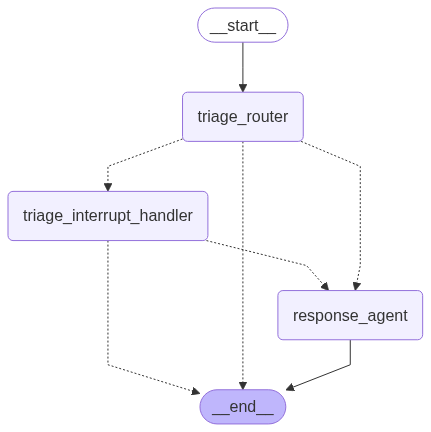

In [56]:
from email_assistant.utils import show_graph

# Conditional edge function
def should_continue(state: State, store: BaseStore) -> Literal["interrupt_handler", END]:
    """Route to tool handler, or end if Done tool called"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "interrupt_handler"

# Build workflow
agent_builder = StateGraph(State)

# Add nodes - with store parameter
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("interrupt_handler", interrupt_handler)

# Add edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "interrupt_handler": "interrupt_handler",
        END: END,
    },
)

# Compile the agent
response_agent = agent_builder.compile()

# Build overall workflow with store and checkpointer
overall_workflow = (
    StateGraph(State, input=StateInput)
    .add_node(triage_router)
    .add_node(triage_interrupt_handler)
    .add_node("response_agent", response_agent)
    .add_edge(START, "triage_router")
)

email_assistant = overall_workflow.compile()
show_graph(email_assistant)